# News headers and tags analysis

In [ ]:
!pip install -Uq pip setuptools wheel
!pip install -Uq spacy
!python -m spacy download es_core_news_lg
!python -m spacy download es_dep_news_trf
!pip install -q fsspec

distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
2021-07-28 00:06:37.585385: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
distutils: /usr/local/lib/

In [ ]:
import json
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = '/content/drive/Shareddrives/Data Mining 2021/Project - DataMining/News/'
#urls_path = root_path + 'urls.json'
#crawled_path = root_path + 'crawled.json'

semana_urls_path = root_path + 'data/semana/urls.json'
semana_crawled_path = root_path + 'data/semana/crawled.json'

eltiempo_urls_path = root_path + 'data/eltiempo/urls.json'
eltiempo_crawled_path = root_path + 'data/eltiempo/crawled.json'

In [ ]:
def extractExtra(series):
    extra = series['extra']
    if series['source'] == 'El Tiempo':
        date = pd.to_datetime(extra['unix_date'], unit='s')
        extra_txt = extra['ephigraph']
    elif series['source'] == 'Semana':
        date = pd.to_datetime(extra['string_date'], format='%Y-%m-%d')
        extra_txt = extra['summary']
    else:
        extra_txt, date = '', None
    return pd.Series({
        'date': date,
        'source': series['source'],
        'title': series['title'],
        'extra_txt': extra_txt,
        'url': series['url'],
        'crawled': series['crawled']
    })

def extractTags(series):
    tags = series['extra']['tags']
    if not tags: tags = []
    if '' in tags: tags = list(set(tags) - {''})

    return pd.Series({'tags': tags})

In [ ]:
def load_source(urls_path, crawled_path):
    with open(urls_path) as f:
        raw_json = f.read()
        urls = json.loads(raw_json)['_default']
    with open(crawled_path) as f:
        raw_json = f.read()
        crawled = json.loads(raw_json)['_default']

    df_articles = pd.read_json(StringIO(json.dumps(urls)), orient='index')\
        .apply(extractExtra, axis=1)
    
    df_tags = pd.read_json(StringIO(json.dumps(crawled)), orient='index')\
        .apply(extractTags, axis=1)
    
    return pd.concat([df_articles, df_tags], axis=1)

In [ ]:
df_semana = load_source(semana_urls_path, semana_crawled_path)
df_eltiempo = load_source(eltiempo_urls_path, eltiempo_crawled_path)
df_semana.dropna(axis=0, subset=['tags'], inplace=True)
df_eltiempo.dropna(axis=0, subset=['tags'], inplace=True)
df_semana['date'] = df_semana['date'].dt.date
df_eltiempo['date'] = df_eltiempo['date'].dt.date

In [ ]:
df_articles = pd.concat([df_semana, df_eltiempo])

In [ ]:
# by data source (aka newspaper/news source)
df_articles['source'].value_counts()

Semana       4461
El Tiempo    3465
Name: source, dtype: int64

## NLP preprocessing

We perform some tasks such as removing stop words, and tokenize the remaining words. For tokenization we use to approaches:
* Lemmatization: Extract minimum root(lemma) of the word that has meaning.
* Stemming: Extract the root of the word based on rules. The stem that is extracted does not necessarily have meaning.

In [ ]:
import spacy
import es_dep_news_trf, es_core_news_lg
import re
import nltk
import numpy as np
from tqdm import tqdm
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

In [ ]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english')) # just in case we have an english news source
tokenizer = nltk.WordPunctTokenizer()

nlp = es_dep_news_trf.load() #spacy spanish model

In [ ]:
def tokenize(doc):
    doc = doc.lower()
    doc = re.sub(r'[^a-zA-Záéíóú\s]', '', doc, re.I|re.A) # no special chars
    doc = doc.strip()
    tokens = tokenizer.tokenize(doc)
    tokens = [t for t in tokens if t not in stop_words_sp and len(t) > 2]
    return tokens

def lemmatize(doc):
    doc = doc.lower()
    tokens = nlp(doc)
    lemmas = []
    for token in tokens:
        lemmas.append(token.lemma_)
    lemmas = [l for l in lemmas if l not in stop_words_sp and len(l) > 2]
    return lemmas

def preprocessing_lem(doc):
    lemmas = lemmatize(doc)
    return ' '.join(lemmas)
def preprocessing_tok(doc):
    tokens = tokenize(doc)
    return ' '.join(tokens)

Use reload=True to avoid reprocessing, otherwise it will tokenize(stemming) and lemmatize all the titles again.

In [ ]:
reload = True # True if we want to reload from checkpoint

semana_titles, tk_semana_titles, lm_semana_titles = [], [], []
eltiempo_titles, tk_eltiempo_titles, lm_eltiempo_titles = [], [], []
tk_all, lm_all = [], []

if reload: # Reload from checkpoint
    df_articles = pd.read_csv(root_path + 'checkpoint_1.csv')
    df_articles['tokens'] = df_articles['tokens'].apply(eval)
    df_articles['lemmas'] = df_articles['lemmas'].apply(eval)
    df_articles['tags'] = df_articles['tags'].apply(eval)
    df_articles['date'] = pd.to_datetime(df_articles['date'])

    for idx, s in df_articles.iterrows():
        source = s['source']
        tokenized = s['tokens']
        lemmatized = s['lemmas']
        lm_title = ' '.join(lemmatized)
        if source == 'Semana':
            tk_semana_titles.append(tokenized)
            lm_semana_titles.append(lemmatized)
            semana_titles.append(lm_title)
        if source == 'El Tiempo':
            tk_eltiempo_titles.append(tokenized)
            lm_eltiempo_titles.append(lemmatized)
            eltiempo_titles.append(lm_title)
        tk_all.append(tokenized)
        lm_all.append(lemmatized)
else: #Process All and save checkpoint
    news_source = []
    news_title = []
    for idx, info in df_articles.iterrows():
        news_title.append(info['title'])
        news_source.append(info['source'])
    for source, title in tqdm(list(zip(news_source, news_title))):
        tokenized = tokenize(title)
        lemmatized = lemmatize(title)
        lm_titles = preprocessing_lem(title)
        #tk_titles = preprocessing_tok(title)
        if source == 'Semana': 
            tk_semana_titles.append(tokenized)
            lm_semana_titles.append(lemmatized)
            semana_titles.append(lm_titles)
        elif source == 'El Tiempo':
            tk_eltiempo_titles.append(tokenized)
            lm_eltiempo_titles.append(lemmatized)
            eltiempo_titles.append(lm_titles)
        tk_all.append(tokenized)
        lm_all.append(lemmatized)

    df_articles['tokens'] = tk_all
    df_articles['lemmas'] = lm_all
    df_articles.to_csv(root_path + 'checkpoint_1.csv', index=False)

In [ ]:
df_articles.head()

,date,source,title,extra_txt,url,crawled,tags,tokens,lemmas
0,2021-06-05,Semana,Tribunal de Cundinamarca le pidió al president...,El primer mandatario deberá explicar por qué c...,https://www.semana.com/nacion/articulo/tribuna...,True,"[Ejército Nacional, Tribunal Administrativo de...","[tribunal, cundinamarca, pidió, presidente, du...","[tribunal, cundinamarca, pedir, presidente, du..."
1,2021-06-05,Semana,¿Qué se creen?,"En realidad, asistimos a una nueva forma de ha...",https://www.semana.com/opinion/articulo/que-se...,True,"[elecciones, Procuraduría, Opinión, María Andr...",[creen],[creer]
2,2021-06-05,Semana,Perú se la juega en las elecciones presidencia...,El futuro del país vecino es incierto. ¿Keiko ...,https://www.semana.com/mundo/articulo/peru-se-...,True,"[Mundo, Perú, Keiko Fujimori]","[perú, juega, elecciones, presidenciales, keik...","[perú, jugar, elección, presidencial, keiko, f..."
3,2021-06-05,Semana,Entrevista Exclusiva: Marta Lucía Ramírez sí i...,"En entrevista con SEMANA, la vicepresidenta Ma...",https://www.semana.com/nacion/articulo/entrevi...,True,"[Marta Lucía Ramírez, Cancillería, Iván Duque,...","[entrevista, exclusiva, marta, lucía, ramírez,...","[entrevista, exclusivo, marta, lucir, ramírez,..."
4,2021-06-05,Semana,"Armas traumáticas, peligrosos juguetes que matan","Se pueden comprar en un local comercial, no ti...",https://www.semana.com/nacion/articulo/armas-t...,True,"[Policía, Cali, Ministerio de Defensa]","[armas, traumáticas, peligrosos, juguetes, matan]","[arma, traumática, peligroso, juguete, matar]"


## Lemma frequency

Here we perform a simple frequency visualization of the most common words among documents

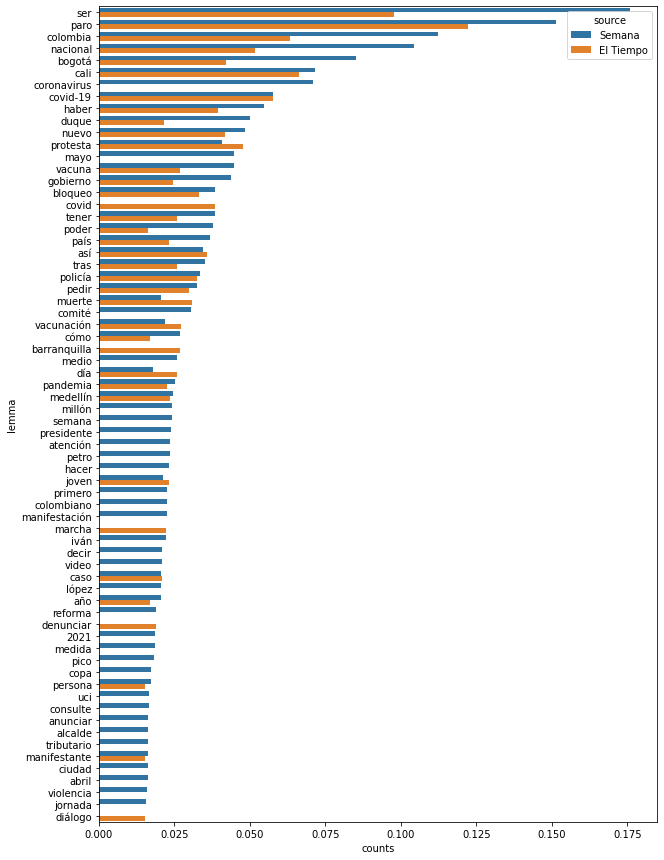

In [ ]:
semana_lemmas = [token for tokens in lm_semana_titles for token in tokens]
tks, cnts = np.unique(semana_lemmas, return_counts=True)
semana_counts = pd.DataFrame({'lemma': tks, 'counts':cnts/len(semana_titles)})
semana_counts['source'] = 'Semana'

eltiempo_lemmas = [token for tokens in lm_eltiempo_titles for token in tokens]
tks, cnts = np.unique(eltiempo_lemmas, return_counts=True)
eltiempo_counts = pd.DataFrame({'lemma': tks, 'counts':cnts/len(eltiempo_titles)})
eltiempo_counts['source'] = 'El Tiempo'

counts_df = pd.concat([semana_counts, eltiempo_counts]).sort_values(by='counts', ascending=False).head(100)

plt.figure(figsize=(10,15))
sns.barplot(data=counts_df, x='counts', y='lemma', hue='source')

The plot above shows that the usage of some words differ among newspapers. To be able to compare both, we scaled the counts by the number of availabe for each newspaper. We also do a word clouds with these lemmas:

### Word clouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
semana_lemmas = [l for l in semana_lemmas if l !='ser']
eltiempo_lemmas = [l for l in eltiempo_lemmas if l!='ser']

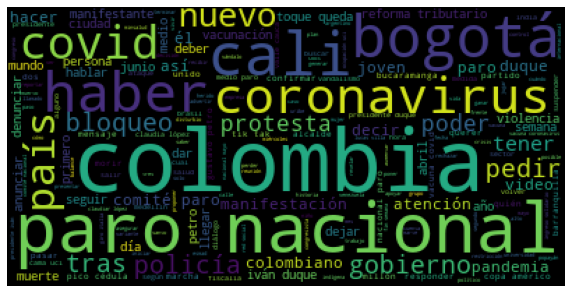

In [ ]:
txt = ' '.join(semana_lemmas)
wordcloud = WordCloud().generate(text=txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

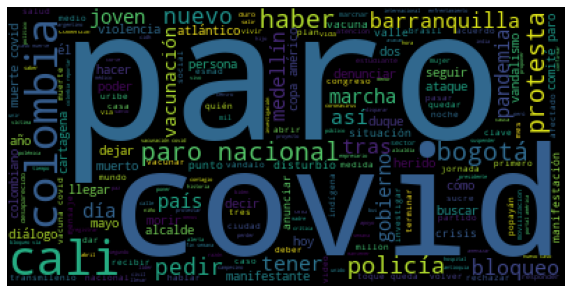

In [ ]:
txt = ' '.join(eltiempo_lemmas)
wordcloud = WordCloud().generate(text=txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Temporal

In [ ]:
def find_in_time(df_source, tokens, use_lemmas=False):
    df_found = df_source[['date', 'source', 'tokens']]\
    .apply(lambda x: pd.Series({
        'date':x['date'],
        'source': x['source'],
        'found': any([t in x['tokens' if not use_lemmas else 'lemmas'] for t in tokens])
    }), axis=1).groupby(by=['date', 'source']).sum()
    return df_found.reset_index()

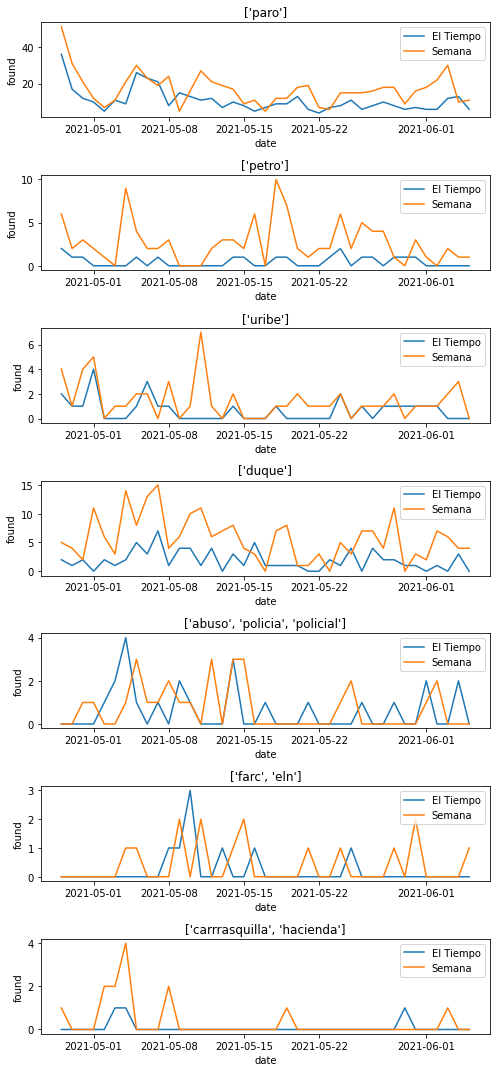

In [ ]:
terms = [['paro'], ['petro'], ['uribe'], ['duque'], ['abuso', 'policia', 'policial'], ['farc', 'eln'], ['carrrasquilla', 'hacienda']]

fig = plt.figure(figsize=(7, 15))
for i, term_set in enumerate(terms):
    word_counts = find_in_time(df_articles, term_set)
    plt.subplot(len(terms),1,i+1)
    sns.lineplot(data=word_counts, x='date', y='found', hue='source')
    plt.title(term_set)
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Tag clustering

We want to build association rules with the tags that are found on the articles. The problem with this is that the tags from both sources are likely to be generated with some topic extraction algorithm, therefore we might have topics that mean the same, but are written slightly different.

Here we intend to perform some deduplication tasks to reduce this issue, and obtain better association rules.

### Tag deduplication (with agglomerative clustering)

**Why agglomerative clustering?** The reason for this was basically that the bottom-up approach is quite similar too the KNN technique for classification. It tries to group close groups based on a similarity (jaccard) and a linkage method helps us determining the 'closeness' within groups. We want to group together those tags that are similar lexicographically, therefore jaccard seems ideal with agglomerative clustering.

DBScan might be usefull too, but the tunning is quite complicated, and due to its nature, it could link together unrelated tags in succesion (reachable and core points).

We do not use KMeans because one of the biggest issues is how we initialize centroids and how it recalculate these on each iteration (one-hot encoding is disperse for this dataset). Maybe with a different embedding (not one-hot encoding), we can have interesting results.

In [ ]:
semana_tags = [t.lower() for tags in df_articles[df_articles['source'] == 'Semana']['tags'].values for t in tags]
eltiempo_tags = [t.lower() for tags in df_articles[df_articles['source'] == 'El Tiempo']['tags'].values for t in tags]

In [ ]:
def get_unique_tags(tags):
    unique_tags = dict()# {tag: id}
    encoding = []
    i = 0
    flag=True
    for t in tags:
        id = unique_tags.get(t)
        if id == None:
            unique_tags[t] = i
            encoding.append(i)
            i+=1
        else:
            encoding.append(id)
    return unique_tags, encoding

semana_unique_tags, semana_tags_encoding = get_unique_tags(semana_tags)
eltiempo_unique_tags, eltiempo_tags_encoding = get_unique_tags(eltiempo_tags)

In [ ]:
# mapping of lemmas and original tags.
semana_tags_lemmas = dict()
eltiempo_tags_lemmas = dict()
for t in tqdm(semana_unique_tags.keys()):
    semana_tags_lemmas[t] = preprocessing_lem(t)

for t in tqdm(eltiempo_unique_tags.keys()):
    eltiempo_tags_lemmas[t] = preprocessing_lem(t)

100%|██████████| 2617/2617 [03:06<00:00, 14.00it/s]


In [ ]:
def jaccard_similarity(a, b):
    a = set(a.split())
    b = set(b.split())
    intersect = a.intersection(b)
    return len(intersect) / len(a | b)

In [ ]:
idx=2
print(list(semana_tags_lemmas.values())[idx])
similarties = [(jaccard_similarity(list(semana_tags_lemmas.values())[idx], t), t) for t in semana_tags_lemmas]
print(sorted(similarties, reverse=True)[:10])

iván duque
[(1.0, 'iván duque'), (0.5, 'presidente iván duque márquez'), (0.5, 'gobierno de iván duque'), (0.3333333333333333, 'iván márquez'), (0.3333333333333333, 'iván marulanda'), (0.3333333333333333, 'iván cepeda'), (0.3333333333333333, 'gobierno duque'), (0.25, 'óscar iván zuluaga'), (0.25, 'jorge iván ospina'), (0.25, 'gabinete de duque')]


We need to group the similar ones to reduce the number of tags and generate better asociation rules. Because we need to compare the tags lexicographically, and group the closest ones, we decided to use Agglomerative clustering and jaccard distance.

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import jaccard, pdist, hamming
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as shc

We try with ngrams because there might happen some cases that group together unrelated tags. For example, there are tags that are people names such as 'alejandro gaviria' (cyclist) and 'alejandro ordoñez' (politician). These tags are similar because of the first name, but the topics these people relate to have no correlation.

Another problematic case might be iván duque, and iván marulanda. Both are politicians, but from different political parties.

In [ ]:
count_vect = CountVectorizer(ngram_range=(1,3))
X_semana = count_vect.fit_transform(list(semana_tags_lemmas.values())).toarray()
count_vect = CountVectorizer(ngram_range=(1,3))
X_eltiempo = count_vect.fit_transform(list(eltiempo_tags_lemmas.values())).toarray()

In [ ]:
print(X_semana.shape)
print(X_eltiempo.shape)

(2327, 4398)
(2617, 3763)


In [ ]:
def scoring(fn, attribs):
    try:s = fn(**attribs)
    except: s = 0
    finally: return s

def evaluate_agglomerative_clust(X, methods, cluster_size):
    options = np.array(np.meshgrid(methods, cluster_size)).T.reshape(-1,2)
    scores = {m: {s:[] for s in ['silouetthe', 'davies_bouldin']} for m in methods}
    
    distances = pairwise_distances(X, metric='jaccard')

    for option in tqdm(options):
        method, n_clusters = option
        linkage = shc.linkage(X, method=method, metric='jaccard')
        clusters = shc.cut_tree(linkage, n_clusters=n_clusters).flatten()
        scores[method]['silouetthe'].append(scoring(silhouette_score, {'X': distances, 'labels': clusters, 'metric': 'precomputed'}))
        scores[method]['davies_bouldin'].append(scoring(davies_bouldin_score, {'X': X, 'labels': clusters}))

    return scores

def plot_linkage_score(scores, cluster_size, methods):
    plt.figure(figsize=(10,7))
    plt.subplot(211)
    for m in methods:
        plt.plot(cluster_size, scores[m]['silouetthe'], label=m)
    plt.title('avg silouetthe score')
    plt.xlabel('clusters')
    plt.ylabel('score')
    plt.legend()

    plt.subplot(212)
    for m in methods:
        plt.plot(cluster_size, scores[m]['davies_bouldin'], label=m)
    plt.title('davies_bouldin score')
    plt.xlabel('clusters')
    plt.ylabel('score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
methods = ['average', 'single', 'complete']

cluster_size = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
scores_semana = evaluate_agglomerative_clust(X_semana, methods, cluster_size)

cluster_size = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250]
scores_eltiempo = evaluate_agglomerative_clust(X_eltiempo, methods, cluster_size)

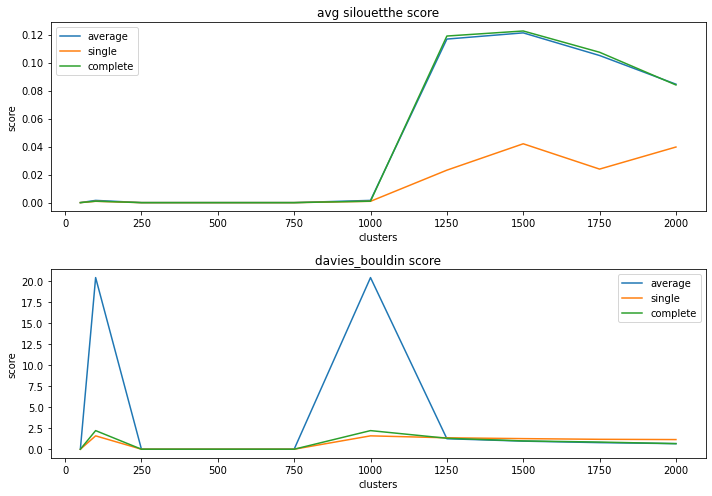

In [ ]:
# Semana
methods = ['average', 'single', 'complete']
cluster_size = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
plot_linkage_score(scores_semana, cluster_size, methods)

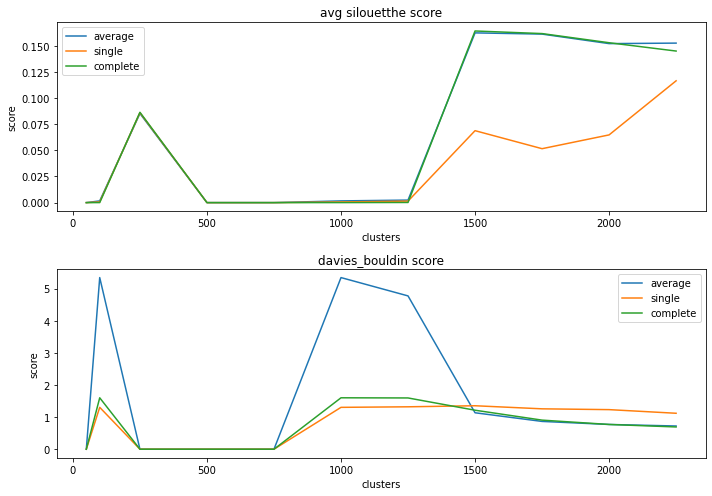

In [ ]:
# Eltiempo
methods = ['average', 'single', 'complete']
cluster_size = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250]
plot_linkage_score(scores_eltiempo, cluster_size, methods)

In [ ]:
# Best model semana
linkage_semana = shc.linkage(X_semana, method='average', metric='jaccard')
clusters_semana = shc.cut_tree(linkage_semana, n_clusters=1500).flatten()

# Best model eltiempo
linkage_eltiempo = shc.linkage(X_eltiempo, method='average', metric='jaccard')
clusters_eltiempo = shc.cut_tree(linkage_eltiempo, n_clusters=1500).flatten()

Now we test the clusters yielded in the sample that was given before

In [ ]:
def show_cluster(elements, clusters, id):
    filter = clusters == id
    cluster_elements = []
    for i, f in enumerate(filter):
        if f: cluster_elements.append(elements[i])
    return cluster_elements

def check_cluster(clusters, tags_lemmas, idx):
    print("element:", list(tags_lemmas.values())[idx])
    print("cluster id:", clusters[idx])
    print("clustered elements:", show_cluster(list(tags_lemmas.values()), clusters, clusters[idx]))

    print("jaccard similarities")
    similarties = [(jaccard_similarity(list(tags_lemmas.values())[idx], t), t) for t in tags_lemmas]
    print(sorted(similarties, reverse=True)[:10])

In [ ]:
check_cluster(clusters_semana, semana_tags_lemmas, 2)

element: iván duque
cluster id: 2
clustered elements: ['iván duque', 'gobierno iván duque', 'presidente iván duque márquez']
jaccard similarities
[(1.0, 'iván duque'), (0.5, 'presidente iván duque márquez'), (0.5, 'gobierno de iván duque'), (0.3333333333333333, 'iván márquez'), (0.3333333333333333, 'iván marulanda'), (0.3333333333333333, 'iván cepeda'), (0.3333333333333333, 'gobierno duque'), (0.25, 'óscar iván zuluaga'), (0.25, 'jorge iván ospina'), (0.25, 'gabinete de duque')]


To get this "good" level of tag reduction, the two key factors where the fact that we considered ngrams instead of single words when we generated the binarization, and the way jaccard is used in combination with the complete or the average linkage method.

In [ ]:
# Elements per clusters in semana_tags (top 10)
sizes = sorted([(c, v) for v, c in zip(*np.unique(clusters_semana, return_counts=True))], reverse=True)[:10]
for i, counts in enumerate(sizes):
    print("{}. cluster_id: {}, elements: {}".format(i+1, counts[1], counts[0]))
    print("grouped_tags:", show_cluster(list(semana_tags_lemmas.values()), clusters_semana, counts[1]))

1. cluster_id: 36, elements: 25
grouped_tags: ['mejor colombia', 'colombia', 'influencers colombia', 'selección colombia', 'noticias colombia', 'vicepresidencia colombia', 'hotel colombia', 'epa colombia', 'canciller colombia', 'vacunación colombia', 'vacunas colombia', 'ministro colombia', 'amcham colombia', 'pensiones colombia', 'disturbio colombia', 'colombia humano', 'abeja colombia', 'desempleado colombia', 'ganadería colombia', 'iva colombia', 'colombia rural', 'cabify colombia', 'colombia mayor', 'enfermero colombia', 'niñez colombia']
2. cluster_id: 119, elements: 13
grouped_tags: ['vacuna', 'vacuna coronavirus', 'vacuna coronavirus', 'vacuna coronavirus colombia', 'vacuna', 'vacuna coronavirus', 'vacuna chino coronavirus', 'vacuna moderno', 'vacuna rappi', 'vacuna moderno', 'vacuna coronavirus', 'vacuna coronavirus chile', 'vacuna astrozeneca']
3. cluster_id: 47, elements: 12
grouped_tags: ['reactivación económico covid-19', 'covid-19', 'migrant covid-19', 'departamento covid-

The lexicographical clustering is good enough. Maybe we can improve it to be context aware, using either the context of the article, or even recurring to techinques such as NER (Named Entity Recognition). Anyway, as as proof of concept is good enough.

Now, we need a way to find a "centroid" or a tag that represent each one of these clusters. For this, we will add the tags, and take as "centroid" the cluster closer to this average.

When we say add, we actually mean to perform an and operation among all tags that belongs to a cluster (having into account that we one hot encoded the tags)

In [ ]:
def get_bestcentroid(X, clusters, idx):
    mean = np.where(X[clusters == idx].sum(axis=0) > 0, 1, 0)
    positions = np.where(clusters==idx)[0]
    distance_to_mean = list(map(lambda x: jaccard(mean, x), X[clusters==idx]))
    return positions[np.argmax(distance_to_mean)]

In [ ]:
check_cluster(clusters_semana, semana_tags_lemmas, 2)

element: iván duque
cluster id: 2
clustered elements: ['iván duque', 'gobierno iván duque', 'presidente iván duque márquez']
jaccard similarities
[(1.0, 'iván duque'), (0.5, 'presidente iván duque márquez'), (0.5, 'gobierno de iván duque'), (0.3333333333333333, 'iván márquez'), (0.3333333333333333, 'iván marulanda'), (0.3333333333333333, 'iván cepeda'), (0.3333333333333333, 'gobierno duque'), (0.25, 'óscar iván zuluaga'), (0.25, 'jorge iván ospina'), (0.25, 'gabinete de duque')]


In [ ]:
centroid_position = get_bestcentroid(X_semana, clusters_semana, 2)
print("centroid position:", centroid_position)
print("centroid tag:", list(semana_tags_lemmas.values())[centroid_position])

centroid position: 2
centroid tag: iván duque


Apply to all, and remap the old tags to the new ones:

In [ ]:
def generate_centroids(X, clusters, tags_lemmas):
    centroids = dict()
    for idx in np.unique(clusters):
        centroid_position = get_bestcentroid(X, clusters, idx)
        positions = np.where(clusters == idx)[0]
        for p in positions:
            centroids[p] = list(tags_lemmas.values())[centroid_position]
    return centroids

In [ ]:
semana_centroids = generate_centroids(X_semana, clusters_semana, semana_tags_lemmas)
eltiempo_centroids = generate_centroids(X_eltiempo, clusters_eltiempo, eltiempo_tags_lemmas)

In [ ]:
# semana_tags_lemmas -> {unique_tag: lemmatized tag}
# semana_tags_encoding -> list of ids
# semana_unique_tags -> {unique_tag: id}
# centroids -> {id: centroid}
# ok_tags -> {unique_tag: centroid}

def remap_tags(source_tags, tags_lemmas, unique_tags, centroids):
    ok_tags = dict()
    for item in tags_lemmas.items():
        unique_tag, lemma_tag = item
        idx = unique_tags.get(unique_tag)
        ok_tags[unique_tag] = centroids[idx]
    
    clean_tags = []

    for tags in source_tags:
        new_tags = set()
        for t in tags:
            tag = t.lower()
            new_tags.add(ok_tags.get(tag))
        clean_tags.append(list(new_tags))
    return clean_tags

In [ ]:
semana_new_tags = remap_tags(
    df_articles[df_articles['source'] == 'Semana']['tags'].values,
    semana_tags_lemmas,
    semana_unique_tags,
    semana_centroids
)

eltiempo_new_tags = remap_tags(
    df_articles[df_articles['source'] == 'El Tiempo']['tags'].values,
    eltiempo_tags_lemmas,
    eltiempo_unique_tags,
    eltiempo_centroids
)

In [ ]:
df_articles['deduplicated_tags'] = df_articles.apply(lambda x: [], axis=1)

# also lowercase the tags just in case
for id, id_df in enumerate(df_articles[df_articles['source'] == 'Semana'].index):
    df_articles.at[id_df, 'deduplicated_tags'] = semana_new_tags[id]
    df_articles.at[id_df, 'tags'] = [t.lower() for t in df_articles['tags'][id_df]]
for id, id_df in enumerate(df_articles[df_articles['source'] == 'El Tiempo'].index):
    df_articles.at[id_df, 'deduplicated_tags'] = eltiempo_new_tags[id]
    df_articles.at[id_df, 'tags'] = [t.lower() for t in df_articles['tags'][id_df]]

In [ ]:
df_articles

,date,source,title,extra_txt,url,crawled,tags,tokens,lemmas,deduplicated_tags
0,2021-06-05,Semana,Tribunal de Cundinamarca le pidió al president...,El primer mandatario deberá explicar por qué c...,https://www.semana.com/nacion/articulo/tribuna...,True,"[ejército nacional, tribunal administrativo de...","[tribunal, cundinamarca, pidió, presidente, du...","[tribunal, cundinamarca, pedir, presidente, du...","[iván duque, tribunal administrativo cundinama..."
1,2021-06-05,Semana,¿Qué se creen?,"En realidad, asistimos a una nueva forma de ha...",https://www.semana.com/opinion/articulo/que-se...,True,"[elecciones, procuraduría, opinión, maría andr...",[creen],[creer],"[elección, maría andrea nieto, procuraduría, o..."
2,2021-06-05,Semana,Perú se la juega en las elecciones presidencia...,El futuro del país vecino es incierto. ¿Keiko ...,https://www.semana.com/mundo/articulo/peru-se-...,True,"[mundo, perú, keiko fujimori]","[perú, juega, elecciones, presidenciales, keik...","[perú, jugar, elección, presidencial, keiko, f...","[keiko fujimori, perú, mundo]"
3,2021-06-05,Semana,Entrevista Exclusiva: Marta Lucía Ramírez sí i...,"En entrevista con SEMANA, la vicepresidenta Ma...",https://www.semana.com/nacion/articulo/entrevi...,True,"[marta lucía ramírez, cancillería, iván duque,...","[entrevista, exclusiva, marta, lucía, ramírez,...","[entrevista, exclusivo, marta, lucir, ramírez,...","[iván duque, marta lucir ramírez, partido, can..."
4,2021-06-05,Semana,"Armas traumáticas, peligrosos juguetes que matan","Se pueden comprar en un local comercial, no ti...",https://www.semana.com/nacion/articulo/armas-t...,True,"[policía, cali, ministerio de defensa]","[armas, traumáticas, peligrosos, juguetes, matan]","[arma, traumática, peligroso, juguete, matar]","[policía, ministerio, cali]"
...,...,...,...,...,...,...,...,...,...,...
7921,2021-04-30,El Tiempo,Autoridades no descartan que bandas estén detr...,Ministro de Defensa ofrece recompensa por resp...,https://www.eltiempo.com/colombia/cali/cali-no...,True,"[cali, manifestaciones, vandalismo, protestas]","[autoridades, descartan, bandas, detrás, vanda...","[autoridad, descartar, banda, detrás, vandalis...","[vandalismo, protesta, manifestación, cali]"
7922,2021-04-30,El Tiempo,Así funciona TransMilenio hoy 30 de abril,Estas son las estaciones que están operando en...,https://www.eltiempo.com/bogota/transmilenio-h...,True,"[bogotá, transmilenio, transporte, transporte ...","[así, funciona, transmilenio, hoy, abril]","[así, funcionar, transmilenio, hoy, abril]","[público, transporte, movilidad, bogotá, trans..."
7923,2021-04-29,El Tiempo,Mejor enseñar a pescar,Un padre o madre agradecen más tener un trabaj...,https://www.eltiempo.com/opinion/cartas/cartas...,True,[],"[mejor, ensear, pescar]","[mejor, enseñar, pescar]",[]
7924,2021-04-29,El Tiempo,'El ángel exterminador',Este momento se parece a esos episodios de la ...,https://www.eltiempo.com/opinion/columnistas/t...,True,[],"[ángel, exterminador]","[ángel, exterminador]",[]


### Embeddings and clustering(KMeans)

Simple Model. We use w2v and KMeans as the algorithms to group.

Here we try to group together some tags using w2v embeddings. This result might be different from what we did above, and the results that we expect might be related with the kind of information the each tag hold, which are mainly named entities. In this regard we expect it group together names of organizations, peoples names, countries names, etc.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA

In [ ]:
nlp = es_core_news_lg.load()

In [ ]:
semana_tags = [t for tags in df_articles[df_articles['source'] == 'Semana']['tags'].values for t in tags]
tags, cnt = np.unique(semana_tags, return_counts=True)

In [ ]:
vectors = []
for tag in tqdm(tags):
    tokens = nlp(str(tag))
    vect = np.sum([token.vector for token in tokens], axis=0)
    vectors.append(vect)

100%|██████████| 2329/2329 [00:16<00:00, 140.09it/s]


In [ ]:
n_clusters = np.arange(2, 50, 2)
inertia = []
for n in tqdm(n_clusters):
    model = KMeans(n_clusters=n)
    model.fit(vectors)
    inertia.append(model.inertia_)

100%|██████████| 24/24 [00:42<00:00,  1.77s/it]


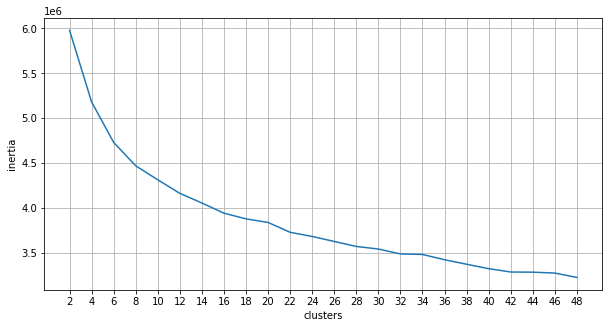

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(n_clusters, inertia)
plt.xticks(n_clusters)
plt.xlabel('clusters')
plt.ylabel('inertia')
plt.grid()
plt.show()

In [ ]:
model = KMeans(n_clusters=10)
model.fit(vectors)
labels = model.predict(vectors)

In [ ]:
tags = np.array(tags)

In [ ]:
tags[labels == 0][:20]

array(['Alejandro Riaño en su papel de Juanpis González',
       'Avianca en ley de quiebras', 'Aviones de combate en Colombia',
       'Belén de Bajirá es de Antioquia o Chocó',
       'Caimanes en peligro de extinción',
       'Casos de coronavirus en Argentina',
       'Casos de coronavirus en Colombia',
       'Casos de coronavirus en el mundo', 'Cortes de agua en Bogotá',
       'Cortes de luz en Bogotá', 'Cámara de Comercio de Bogotá',
       'Cáncer de mama en Colombia',
       'Delimitación del Páramo de Santurbán',
       'Departamento de Estado de Estados Unidos',
       'Empresa de Acueducto y Alcantarillado de Bogotá',
       'Escasez de combustible en Pasto',
       'Fernando Gaviria en Giro de Italia', 'Grupo de Energía de Bogotá',
       'Mejores universidades de Colombia en 2020',
       'Ministerio de Relaciones Exteriores de Colombia'], dtype='<U56')

As we mentioned before, here we have an example of tags whose common denominator is that in its name it has a country, city, etc.

In [ ]:
tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=10)
T = tsne.fit_transform(vectors)

This is interesting, because it grouped together some stuff such as people names, business names, places, etc., and with a TNSE representation we can visualize some this behaviour

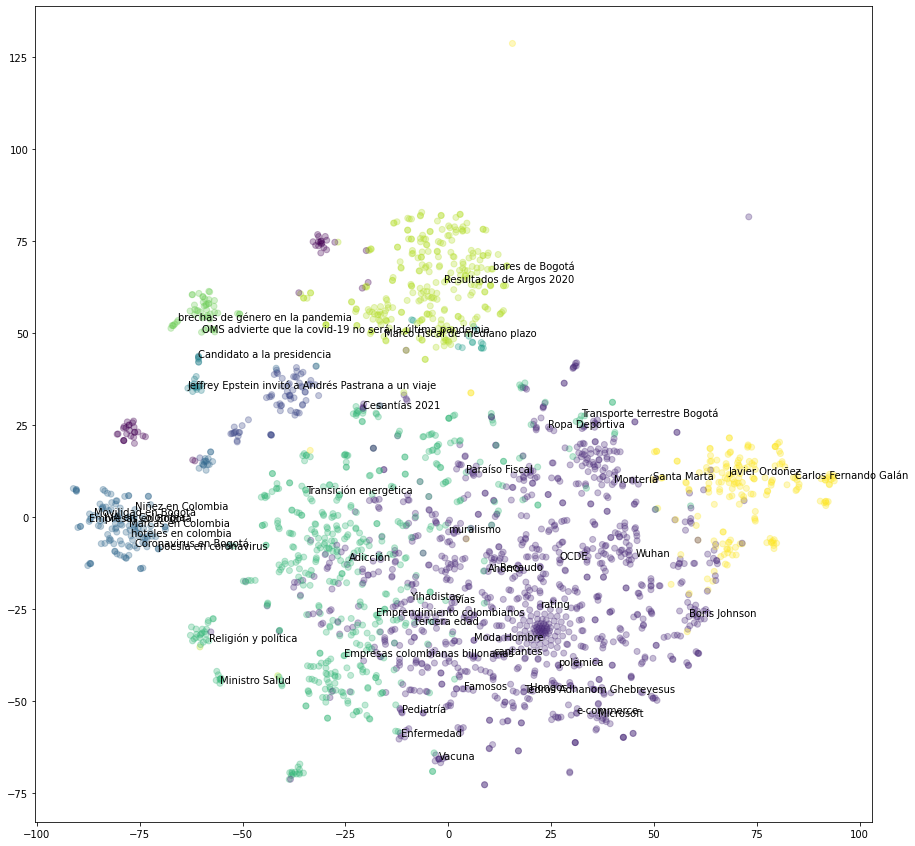

In [ ]:
plt.figure(figsize=(15,15))
n_docs=50
idx = np.arange(len(tags))
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(T[:, 0], T[:, 1], alpha=0.3, c=labels)
plot_titles=[tags[i] for i in valid_idx]
for label, x, y in zip(plot_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

## Association Rules

We build association rules from the tags we preprocessed beforehand. As a comparison method, we will generate association rules using both the original tags and the ones we deduplicated.

In [ ]:
!pip install -q pyfpgrowth efficient_apriori
from efficient_apriori import apriori
import pyfpgrowth

distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 1.6 MB 5.3 MB/s 
  distutils: /usr/local/include/python3.7/pyfpgrowth
  sysconfig: /usr/include/python3.7m/pyfpgrowth
  distutils: /usr/local/include/python3.7/efficient-apriori
  sysconfig: /usr/include/python3.7m/efficient-apriori


In [ ]:
print("UNIQUE TAGS SEMANA:", len(semana_unique_tags))
print("UNIQUE TAGS EL TIEMPO:", len(eltiempo_unique_tags))

UNIQUE TAGS SEMANA: 2327
UNIQUE TAGS EL TIEMPO: 2617


In [ ]:
semana_tags = [tags for tags in df_articles[df_articles['source'] == 'Semana']['tags'].values]
eltiempo_tags = [tags for tags in df_articles[df_articles['source'] == 'El Tiempo']['tags'].values]
semana_new_tags = [tags for tags in df_articles[df_articles['source'] == 'Semana']['deduplicated_tags'].values]
eltiempo_new_tags = [tags for tags in df_articles[df_articles['source'] == 'El Tiempo']['deduplicated_tags'].values]

With an association rule such as $X \rightarrow Y$, we have the following 'metrics':

$$support = \frac{freq(X, Y)}{N}$$
$$confidence = \frac{freq(X, Y)}{freq(X)}$$

In the case of the document tags, it means that the support its the ratio in which a set of tags appears along all the documents ($N$).

###  Semana

Here we use the new deduplicated tags

In [ ]:
itemsets, rules = apriori(semana_new_tags, min_support=0.001, min_confidence=0.01)

In [ ]:
for r in rules:
    if r.support > 0.001 and r.confidence > 0.5:
        print(r)

{violencia} -> {paro nacional} (conf: 0.645, supp: 0.004, lift: 2.439, conv: 2.073)
{carretera} -> {paro nacional} (conf: 0.680, supp: 0.016, lift: 2.569, conv: 2.296)
{mundial catar 2022} -> {colombia} (conf: 0.800, supp: 0.005, lift: 11.015, conv: 4.637)
{fiscalía general nación} -> {paro nacional} (conf: 0.562, supp: 0.002, lift: 2.127, conv: 1.681)
{manifestación} -> {paro nacional} (conf: 0.701, supp: 0.015, lift: 2.650, conv: 2.460)
{fecode} -> {paro nacional} (conf: 0.667, supp: 0.002, lift: 2.520, conv: 2.206)
{maría isabel rueda} -> {paro nacional} (conf: 0.786, supp: 0.007, lift: 2.970, conv: 3.432)
{extinción dominio} -> {fiscalía} (conf: 1.000, supp: 0.001, lift: 85.788, conv: 988343420.758)
{movilidad} -> {transmilenio} (conf: 0.594, supp: 0.004, lift: 35.316, conv: 2.420)
{marchas} -> {paro nacional} (conf: 0.643, supp: 0.018, lift: 2.430, conv: 2.059)
{esmad} -> {paro nacional} (conf: 0.600, supp: 0.009, lift: 2.268, conv: 1.839)
{cidh} -> {paro nacional} (conf: 0.720, s

Here is a list of interesting rules we have found:

* {diego molano, naciones unidas, paro nacional} -> {reforma tributario} (conf: 1.000, supp: 0.001, lift: 27.881, conv: 964133602.331)
* {comercio, fenalco} -> {paro nacional} (conf: 0.833, supp: 0.001, lift: 3.150, conv: 4.413)
* {bogotá, ley} -> {toque queda} (conf: 1.000, supp: 0.001, lift: 78.263, conv: 987222595.831)
* {minga indígena} -> {cali} (conf: 0.528, supp: 0.004, lift: 8.204, conv: 1.981)
* {minga indígena} -> {paro nacional} (conf: 0.556, supp: 0.004, lift: 2.100, conv: 1.655)
* {pereira} -> {lucas villa} (conf: 0.667, supp: 0.003, lift: 114.385, conv: 2.983)
* {esmad} -> {paro nacional} (conf: 0.600, supp: 0.009, lift: 2.268, conv: 1.839)
* {manifestación} -> {paro nacional} (conf: 0.701, supp: 0.015, lift: 2.650, conv: 2.460)

> Something important to have into account is that the support is not that relevant in this case, because we have a lot of tags, and there might be tags that only appear once or twice among all the documents. We tried to mitigate this with the tag deduplication executed before, but even with that, we still having around 1500 potential tags and its unsure if the frecuency of some of the infrequent tags improved.

In [ ]:
patterns = pyfpgrowth.find_frequent_patterns(semana_new_tags, support_threshold=0.01)
rules = pyfpgrowth.generate_association_rules(patterns, 0.01) # min confidence

In [ ]:
br = 1
for k, v in rules.items():
    if v[1] > 0.9 and  v[1] <= 1.0:
        print(k, "->", v[0], " - ", v[1])
        br+=1
    if br == 500: break

('cancion',) -> ('medellín', 'paro')  -  1.0
('cancion', 'medellín') -> ('paro',)  -  1.0
('cancion', 'paro') -> ('medellín',)  -  1.0
('yerry mina',) -> ('colombia', 'guillermo lasso', 'memes', 'mundial')  -  1.0
('guillermo lasso', 'memes') -> ('colombia', 'mundial')  -  1.0
('guillermo lasso', 'yerry mina') -> ('colombia', 'memes', 'mundial')  -  1.0
('memes', 'yerry mina') -> ('colombia', 'guillermo lasso', 'mundial')  -  1.0
('memes', 'mundial') -> ('colombia', 'guillermo lasso')  -  1.0
('mundial', 'yerry mina') -> ('colombia', 'guillermo lasso', 'memes')  -  1.0
('colombia', 'memes') -> ('guillermo lasso', 'mundial')  -  1.0
('colombia', 'yerry mina') -> ('guillermo lasso', 'memes', 'mundial')  -  1.0
('guillermo lasso', 'mundial') -> ('colombia',)  -  1.0
('guillermo lasso', 'memes', 'mundial') -> ('colombia',)  -  1.0
('guillermo lasso', 'memes', 'yerry mina') -> ('colombia', 'mundial')  -  1.0
('guillermo lasso', 'mundial', 'yerry mina') -> ('colombia', 'memes')  -  1.0
('mem

Here is a list of the rules generated with fp-growth:
* ('bogotá', 'protesta', 'vandalismo') -> ('paro',)  -  0.6666666666666666
* ('muerte', 'paro nacional') -> ('esmad',)  -  0.6666666666666666
* ('hongo negro', 'salud') -> ('enfermedad',)  -  0.6666666666666666
* ('alberto fernández', 'fernando gaviria', 'italia') -> ('ciclismo',)  -  0.6666666666666666 **some sports related news are being shown within the dataset**
* ('gustavo petro', 'semana') -> ('paro nacional',)  -  0.625
* ('iván duque', 'jorge iván ospina') -> ('cali',)  -  0.6666666666666666
* ('departamento prosperidad social',) -> ('ingreso', 'subsidio')  -  0.6666666666666666
* ('coronavirus colombia', 'ministerio', 'pandemia') -> ('coronavirus',)  -  0.6666666666666666
* ('contagio', 'vacuna') -> ('coronavirus',)  -  0.92
* ('fake news', 'paro') -> ('noticia',)  -  0.8333333333333334
* ('defensoría', 'desaparecido') -> ('paro',)  -  0.8333333333333334
* ('paro', 'pasto') -> ('nariño',)  -  0.875
* ('claudia lópez', 'covid') -> ('bogotá',)  -  0.8461538461538461
* ('cartagena', 'puertos') -> ('economía', 'exportación', 'importación')  -  1.0
* ('fiscalía general', 'petro', 'procuraduría', 'votos') -> ('derechos humanos',)  -  1.0
* ('icetex', 'pae', 'paro', 'universidades') -> ('educación',)  -  1.0
* ('paramilitar', 'paro', 'uribe') -> ('auc',)  -  1.0

Here is a rule that might be affected by the deduplication:
* ('cali', 'imputación cargo', 'járlinson pantano', 'paro') -> ('fiscalía',)  -  1.0
> Jarlinson Pantano is a cyclist.


### El Tiempo

In [ ]:
itemsets, rules = apriori(eltiempo_new_tags, min_support=0.001, min_confidence=0.01)

In [ ]:
for r in rules:
    if r.support > 0.1 and r.confidence > 0.5:
        print(r)

The rules generated here are similar to the ones observed in semana's set:
* {mundial} -> {colombia} (conf: 0.533, supp: 0.002, lift: 11.268, conv: 2.041)
* {cidh} -> {paro} (conf: 0.594, supp: 0.005, lift: 1.865, conv: 1.678)
* {manifestación} -> {paro} (conf: 0.665, supp: 0.038, lift: 2.089, conv: 2.035)
* {diego molano} -> {censura} (conf: 0.550, supp: 0.003, lift: 112.103, conv: 2.211)
* {arma} -> {policía} (conf: 0.700, supp: 0.002, lift: 13.475, conv: 3.160)
* {cali, manifestación} -> {paro} (conf: 0.636, supp: 0.006, lift: 1.999, conv: 1.875)
* {abuso, policía} -> {paro} (conf: 0.591, supp: 0.004, lift: 1.856, conv: 1.666)
* {marchas, movilidad} -> {paro} (conf: 0.667, supp: 0.001, lift: 2.094, conv: 2.045)
* {atlántico, barranquilla, contagio} -> {covid} (conf: 0.875, supp: 0.002, lift: 6.064, conv: 6.846)

And so on...

For FP-Growth we find association rules such as the ones shown below:

In [ ]:
patterns = pyfpgrowth.find_frequent_patterns(eltiempo_new_tags, support_threshold=0.01)
rules = pyfpgrowth.generate_association_rules(patterns, 0.01) # min confidence

In [ ]:
for k, v in rules.items():
    if v[1] > 0.5 and  v[1] < 0.7:
        print(k, "->", v[0], " - ", v[1])

('niño', 'vacuna') -> ('covid',)  -  0.6666666666666666
('contenidoliberado', 'paro') -> ('noticia',)  -  0.6
('bogotá', 'vandalismo') -> ('paro',)  -  0.5909090909090909
('covid', 'risaralda') -> ('pereira',)  -  0.6666666666666666
('cúcuta', 'santander') -> ('paro',)  -  0.6666666666666666
('cúcuta', 'paro') -> ('santander',)  -  0.6666666666666666
('cali', 'fiscalía', 'paro') -> ('policía',)  -  0.6
('centro democrático', 'noticia') -> ('paro',)  -  0.6666666666666666
('carbón', 'cerrejón') -> ('guajira',)  -  0.6666666666666666
('armada nacional', 'buenaventura') -> ('duque', 'vandalismo')  -  0.6666666666666666
('noticia', 'sucre') -> ('coronavirus',)  -  0.6470588235294118
('cali', 'cauca') -> ('paro',)  -  0.627906976744186
('colombia', 'protesta') -> ('paro',)  -  0.625
('paro', 'violencia') -> ('cali',)  -  0.5192307692307693
('bloqueo', 'cali') -> ('paro',)  -  0.5625
('manifestación', 'protesta') -> ('paro',)  -  0.6607142857142857
('balacera', 'manifestación') -> ('paro',) 

## Topic analysis

Here we use LDA and LSA to find the main topics for each one of the news headers in our dataset.

In [ ]:
%pip install pyLDAvis
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle, pyLDAvis, os

     |████████████████████████████████| 1.7 MB 3.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.3 MB 216 kB/s 
     |████████████████████████████████| 9.9 MB 46.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=e70b1b5c642a3780ce70b6a97dd09be83247a35049483354335579a1305b484c
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



### Semana

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared')

In [ ]:
df_articles['extra_txt'] = df_articles['extra_txt'].replace(np.nan, '')

In [ ]:
def join_texts(series):
    title = series['title'].strip()
    txt = series['extra_txt'].strip() if series['extra_txt'] else ''

    if title[-1] != '.': title +='.'
    full_txt = title + ' ' + txt
    return pd.Series({
        'full_txt': full_txt
    })

df_articles['full_txt'] = df_articles.apply(join_texts,axis=1)

In [ ]:
semana_corpus = [preprocessing_tok(txt) for txt in df_articles[df_articles['source'] == 'Semana']['full_txt'].values]
eltiempo_corpus = [preprocessing_tok(txt) for txt in df_articles[df_articles['source'] == 'El Tiempo']['full_txt'].values]

Using tfidf and LSA

In [ ]:
tfidf = TfidfVectorizer(stop_words=list(stop_words_sp), max_features=None, max_df=0.5, sublinear_tf=True)
tfidf.fit(semana_corpus)
tfidf_semana = tfidf.transform(semana_corpus).toarray()

In [ ]:
bow=CountVectorizer(stop_words=list(stop_words_sp), max_features=None, max_df=0.5)
bow.fit(semana_corpus)
bow_semana=bow.transform(semana_corpus).toarray()

In [ ]:
model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=1234)
model.fit(bow_semana)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=100,
             random_state=1234, tol=0.0)

In [ ]:
def show_top(model, terms):
    for i, comp in enumerate(model.components_):
        terms_comp=zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
        print("Tópico {}: {}".format(i," ".join(list(map(lambda x:x[0], sorted_terms)))))

show_top(model, tfidf.get_feature_names())

Tópico 0: paro nacional colombia país gobierno bogotá duque comité cali medio
Tópico 1: colombia covid coronavirus país bogotá casos salud pandemia vacunas millones
Tópico 2: bogotá cali mayo ciudad uci camas capital covid nacional ocupación
Tópico 3: duque cali presidente iván ciudad reforma tributaria tras valle bogotá
Tópico 4: colombia bogotá cali protestas policía mayo manifestaciones semana violencia manifestantes


Using BOW and LDA

In [ ]:
model = LDA(n_components=5, n_jobs=-1)
model.fit(bow_semana)

show_top(model, bow.get_feature_names())

Tópico 0: colombia país paro américa copa nacional pandemia gobierno millones semana
Tópico 1: cali paro nacional protestas policía personas colombia bogotá violencia medio
Tópico 2: cali policía gobierno paro público colombia fuerza nacional medio pública
Tópico 3: covid coronavirus colombia país salud casos pandemia vacunas vacunación dosis
Tópico 4: paro nacional duque colombia bogotá país presidente mayo gobierno comité


In [ ]:
LDAvis_prepared=sklearn_lda.prepare(model, np.matrix(bow_semana), bow)
pyLDAvis.save_html(LDAvis_prepared, './lda_bow.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.113472  0.146746       1        1  27.030727
1     -0.086866 -0.089229       2        1  20.721221
3      0.204186  0.029976       3        1  18.671200
2     -0.044670 -0.074293       4        1  17.640448
0      0.040822 -0.013200       5        1  15.936405, topic_info=              Term        Freq       Total Category  logprob  loglift
3167   coronavirus  412.000000  412.000000  Default  30.0000  30.0000
3225         covid  427.000000  427.000000  Default  29.0000  29.0000
4485         duque  325.000000  325.000000  Default  28.0000  28.0000
9238          paro  946.000000  946.000000  Default  27.0000  27.0000
2618        comité  213.000000  213.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
8136         medio   35.210261  275.207369   Topic5  -5.9627  -0.2196
3167   coronavirus   37.730447  412.226284   Topic5  -5.8935  -0.5545
11822       social   25.928476   90.674117   Topic5  -6.2686   0.5846
12572         tras   28.899392  234.933579   Topic5  -6.1602  -0.2589
1716      bloqueos   28.474207  244.792428   Topic5  -6.1750  -0.3148

[371 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
18         1  0.975647  abastecimiento
59         1  0.643411           abril
59         2  0.063634           abril
59         3  0.106057           abril
59         4  0.134339           abril
...      ...       ...             ...
13242      1  0.827779            vías
13242      4  0.115260            vías
13242      5  0.052391            vías
13274      4  0.908115          wilson
13333      2  0.965886          álvaro

[671 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

### El Tiempo

Using tfidf and LSA

In [ ]:
tfidf = TfidfVectorizer(stop_words=list(stop_words_sp), max_features=None, max_df=0.5, sublinear_tf=True)
tfidf.fit(eltiempo_corpus)
tfidf_eltiempo = tfidf.transform(eltiempo_corpus).toarray()

In [ ]:
bow=CountVectorizer(stop_words=list(stop_words_sp), max_features=None, max_df=0.5)
bow.fit(eltiempo_corpus)
bow_eltiempo=bow.transform(eltiempo_corpus).toarray()

In [ ]:
model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=1234)
model.fit(bow_eltiempo)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=100,
             random_state=1234, tol=0.0)

In [ ]:
def show_top(model, terms):
    for i, comp in enumerate(model.components_):
        terms_comp=zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
        print("Tópico {}: {}".format(i," ".join(list(map(lambda x:x[0], sorted_terms)))))

show_top(model, tfidf.get_feature_names())

Tópico 0: paro nacional cali gobierno covid protestas colombia bogotá país comité
Tópico 1: covid colombia casos muertes salud nuevos país vacunación barranquilla contagios
Tópico 2: cali policía protestas tras ciudad manifestantes valle bloqueos bogotá alcalde
Tópico 3: colombia país copa gobierno américa situación protestas tras muertes duque
Tópico 4: cali casos muertes paro nuevos colombia salud reportó ministerio nacional


Using BOW and LDA

In [ ]:
model = LDA(n_components=5, n_jobs=-1)
model.fit(bow_eltiempo)

show_top(model, bow.get_feature_names())

Tópico 0: paro cali tras covid presidente pandemia protestas mayo nacional colombia
Tópico 1: covid salud casos muertes colombia paro vacunación uci país nuevos
Tópico 2: paro cali policía tras bloqueos gobierno protestas nacional dos manifestantes
Tópico 3: paro cali nacional protestas queda toque colombia violencia medellín gobierno
Tópico 4: covid paro bogotá colombia nacional país copa así cali américa


In [ ]:
LDAvis_prepared=sklearn_lda.prepare(model, np.matrix(bow_eltiempo), bow)
pyLDAvis.save_html(LDAvis_prepared, './lda_bow.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.065442 -0.029627       1        1  24.720771
4      0.012939  0.130574       2        1  21.268893
1     -0.158095 -0.024255       3        1  20.097278
0      0.029852 -0.011928       4        1  17.424834
3      0.049862 -0.064764       5        1  16.488224, topic_info=         Term        Freq       Total Category  logprob  loglift
2433    covid  358.000000  358.000000  Default  30.0000  30.0000
1620    casos   91.000000   91.000000  Default  29.0000  29.0000
6368  muertes   87.000000   87.000000  Default  28.0000  28.0000
8608    salud  116.000000  116.000000  Default  27.0000  27.0000
9535      uci   63.000000   63.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
873       así   22.140702  150.224525   Topic5  -5.8200  -0.1122
7032     país   22.449373  203.752872   Topic5  -5.8062  -0.4031
3379      día   17.126832   84.751453   Topic5  -6.0768   0.2034
369   alcalde   15.613268   58.791357   Topic5  -6.1693   0.4766
2433    covid   17.271116  358.855836   Topic5  -6.0684  -1.2314

[375 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
31        4  0.747197     aborto
62        1  0.799254      abuso
62        2  0.039963      abuso
62        5  0.159851      abuso
152       3  0.888071    activos
...     ...       ...        ...
9867      5  0.419216  violencia
9869      4  0.139304   violenta
9869      5  0.696520   violenta
9908      4  0.156689      visto
9908      5  0.783445      visto

[693 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

## Grouping News Headers

We try to generate news groupings using the news headers from our dataset. We do not expect great results because the texts are too short to give enough information.

### Alternative embeddings

We use some w2v embeddings, quite similar to what we did with the tags before.

Here we create a function that takes a document and generates a vector that represents the whole document as an average of the embeddings of each word of the document. 

> This approach is good enough, but there are other embeddings like doc2vec that are designed for whole documents. We do not use that here.

In [ ]:
def w2v_avg(doc):
    return np.sum([vectors[w] for w in doc if w in vectors.vocab], axis = 0)
semana_vectors = list(map(w2v_avg, list(map(tokenize, semana_corpus))))

### KMeans

In [ ]:
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

In [ ]:
semana_corpus = df_articles[df_articles['source'] == 'Semana']['full_txt'].values
semana_titles = df_articles[df_articles['source'] == 'Semana']['title'].values
eltiempo_corpus = df_articles[df_articles['source'] == 'El Tiempo']['full_txt'].values
eltiempo_titles = df_articles[df_articles['source'] == 'El Tiempo']['title'].values

In [ ]:
semana_vectors = []
for title in tqdm(semana_corpus):
    tokens = nlp(title)
    vect = np.sum([token.vector for token in tokens], axis=0)
    semana_vectors.append(vect)

100%|██████████| 4461/4461 [01:00<00:00, 73.22it/s]


In [ ]:
inertia = []
n_clusters = [1,2,3,5,8,10,15,20,30,40,50]
for n in tqdm(n_clusters):
    clf = KMeans(n_clusters=n)
    clf.fit(semana_vectors)
    clusters = clf.predict(semana_vectors)
    inertia.append(clf.inertia_)

100%|██████████| 11/11 [00:38<00:00,  3.55s/it]


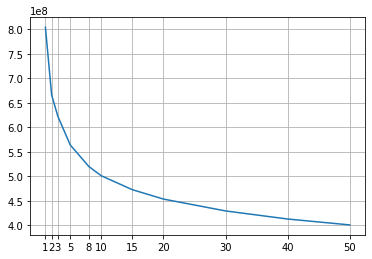

In [ ]:
plt.plot(n_clusters, inertia)
plt.xticks(n_clusters)
plt.grid()

In [ ]:
tsne = TSNE(n_components=2, n_iter=1000)
T = tsne.fit_transform(semana_vectors)

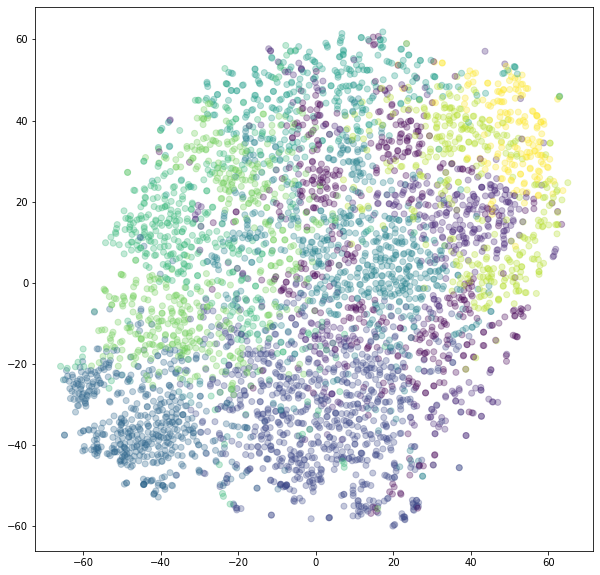

In [ ]:
clf = KMeans(n_clusters=10)
clf.fit(semana_vectors)
clusters = clf.predict(semana_vectors)
plt.figure(figsize=(10, 10))
plt.scatter(T[:, 0], T[:, 1], c=clusters, alpha=0.3)

In [ ]:
def sample_titles(titles, clusters, points, n_elements = 5):
    cluster_ids = np.unique(clusters)
    sample = []
    for id in cluster_ids:
        filtered = titles[clusters == id]

        idx = np.arange(len(filtered))
        valid_idx = np.random.choice(idx, replace=False, size=n_elements)
        plot_titles = [titles[i] for i in valid_idx]
        point_choice = points[valid_idx]
        sample.append([plot_titles, point_choice])
    
    return sample

In [ ]:
sample = sample_titles(semana_titles, clusters, T)
for i, e in enumerate(sample):
    print("CLUSTER {}".format(i))
    for t in e[0]:
        print(">", t)

CLUSTER 0
> Estas son las buenas noticias económicas que tuvo Colombia este lunes
> “No hay excusa para no asegurar la presencialidad a partir del 15 de julio en escuelas y colegios”: MinSalud
> En carta abierta, Pablo Montoya renuncia a eventos culturales organizados por el Gobierno
> “Estamos listos para iniciar la negociación”: Gobierno envió mensaje directo al Comité de Paro
> Las nuevas rutas de las aerolíneas para estas vacaciones
CLUSTER 1
> ¿Acatará la Policía el fallo que ordena entregar nombres de los comandantes del Esmad antes de realizar un procedimiento?
> Empresarios, la verdadera resistencia
> Las nuevas rutas de las aerolíneas para estas vacaciones
> Todas las obras de construcción adelantadas por el IDU se han visto afectadas por las manifestaciones
> “Queremos que la CIDH escuche a todos los afectados, también los casos de dos bebés que murieron por bloqueos”: Marta Lucía Ramírez
CLUSTER 2
> Iván Duque: “Nunca dialogaremos con vías de hecho, eso es chantaje o extorsi

### GMM

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

In [ ]:
gmm_model = GMM(n_components=10)
gmm_model.fit(semana_vectors)
clusters = gmm_model.predict(semana_vectors)

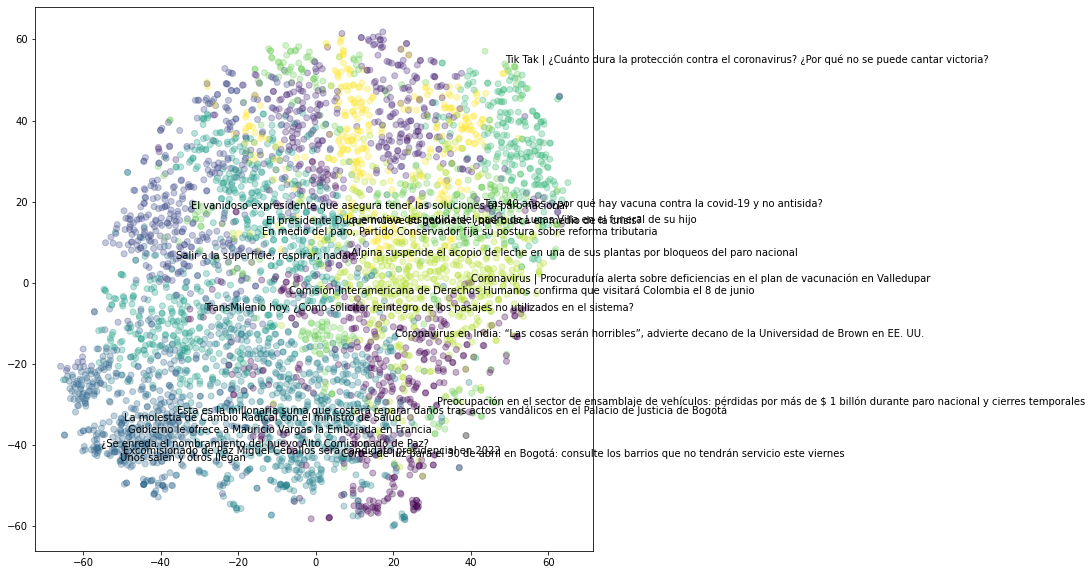

In [ ]:
plt.figure(figsize=(10,10))
n_docs=20
idx = np.arange(len(semana_titles))
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(T[:, 0], T[:, 1], c=clusters, alpha=0.3)
plot_titles=[semana_titles[i] for i in valid_idx]
for label, x, y in zip(plot_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

In [ ]:
sample = sample_titles(semana_titles, clusters, T)
for i, e in enumerate(sample):
    print("CLUSTER {}".format(i))
    for t in e[0]:
        print(">", t)

CLUSTER 0
> “Que nos muestren sus declaraciones de renta”: la solicitud de Mario Hernández al Comité del Paro
> Las seis exigencias controvertidas del Comité Nacional del Paro
> Deportivo Cali vs. Tolima: Dimayor definió estadio, fecha y hora del partido
> Paro nacional | ¿Cuánto le han costado las marchas a la economía colombiana?
> Alcalde de Cali adelantará mesa de diálogo con integrantes de la Primera Línea para avanzar en los desbloqueos
CLUSTER 1
> Paro nacional: dueño del Porsche que atropelló a joven en Bogotá habla en SEMANA
> “Solo se arrodillan ante el dinero”: Matador se va contra los jugadores de la Selección Colombia
> ¿Bogotá y Medellín tendrán toque de queda hoy martes?
> Perú se la juega en las elecciones presidenciales: ¿Keiko Fujimori o Pedro Castillo?
> Imbatible: así fue el rating del partido Perú vs. Colombia por las eliminatorias
CLUSTER 2
> Dólar | En las casas de cambio está más caro que el dólar oficial. ¿Por qué?
> Atención | Moción de censura contra el minis

So far we have tested several grouping algorithms using our embeddings. We have tried to find a way to see the relevance of the clusters, but the texts that are contained within each clusters seems to be unrelated.

One possible reason for these issues is probably the fact that the texts are too short, and therefore the information provided by these is not enough for the clustering using embeddings.